In [5]:
from Bio import SeqIO
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Align import MultipleSeqAlignment
from io import StringIO
from Bio.Seq import Seq 
from Bio.SeqRecord import SeqRecord
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math

The data of the SARS-CoV-2 virus used for this project is curated by [Kunal Joshi & Phillip Compeau](https://compeau.cbd.cmu.edu/online-education/sars-cov-2-software-assignments/sars-cov-2-evolutionary-tree-multiple-alignment-challenge/). The data set includes the sequencing of SARS-CoV-2 taken from 100 randomly selected individuals at six different time points between 2020-11-03 and 2021-12-08 (the data for 2020-11-17 are corrupted).

Only the gene that encodes the spike protein of SARS-CoV-2 virus was used by extracting the nucleotite sequence between positions 21563 and 25384.

The data can be downloaded from [this](http://compeau.cbd.cmu.edu/wp-content/uploads/2021/03/UK-Coronavirus-Data.zip) link.

# Part 1: Loading and Visualization

Reading the FASTA file for the aligned version of the sequences from November 27th data set: HCOV19-ENGLAND-271120-A.fasta. Formatting the  data into a nucleotite matrix of size 100 x 3822.

In [6]:
arr = []

# append spike protein each sequence in the file to the array
with open("UK Coronavirus Data/Coronavirus Samples/England (NOV272020)/HCOV19-ENGLAND-271120-A.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        arr.append(record.seq[21563:25385])
        
nucleotide_matrix = np.array(arr)
print(nucleotide_matrix.shape)
nucleotide_matrix

(100, 3822)


array([['T', 'G', 'T', ..., 'A', 'A', 'A'],
       ['T', 'G', 'T', ..., 'A', 'A', 'A'],
       ['T', 'G', 'T', ..., 'A', 'A', 'A'],
       ...,
       ['T', 'G', 'T', ..., 'A', 'A', 'A'],
       ['T', 'G', 'T', ..., 'A', 'A', 'A'],
       ['T', 'G', 'T', ..., 'A', 'A', 'A']], dtype='<U1')

Detecting any characters in the sequences other than ‘A’, ‘T’, ‘C’, ‘G’, and ‘-’, and converting all of them to ‘-’.

In [5]:
# change characters other than "A", "G", "T", "C" to "-"
for i in range(100):
    for j in range(3822):
        if nucleotide_matrix[i,j] not in ["A", "G", "T", "C", "-"]:
            nucleotide_matrix[i,j] = "-"         

Taking the first 25 samples from November 27th data set, and visualizing the first 250 nucleotides of the spike protein gene in the form of a color matrix, such that each nucleotide is represented by a different color and empty characters are left white.

In [6]:
trimmed_nucleotide = nucleotide_matrix[:25, :250] # taking the first 25 observations and 250 nucleotides

In [7]:
# create a seperate color matrix and for the corresponding rgb values for each nucleotide
color_matrix = []

for i in range(25):
    # create a color_row for each row in the trimmed_nucleotide
    row = list() 
    # iterate through columns and add a corresponding rgb value to color_row
    for j in range(250):
        
        if trimmed_nucleotide[i,j] == "T": 
            row.append((255,219,157)) # yellow
        elif trimmed_nucleotide[i,j] == "G":
            row.append((235,81,83)) # red
        elif trimmed_nucleotide[i,j] == "A":
            row.append((198,205,76)) # green
        elif trimmed_nucleotide[i,j] == "C":
            row.append((123,147,248)) # blue
        else:
            row.append((255, 255, 255)) # white: empty character
            
    # append color_row to the color_matrix
    color_matrix.append(row)

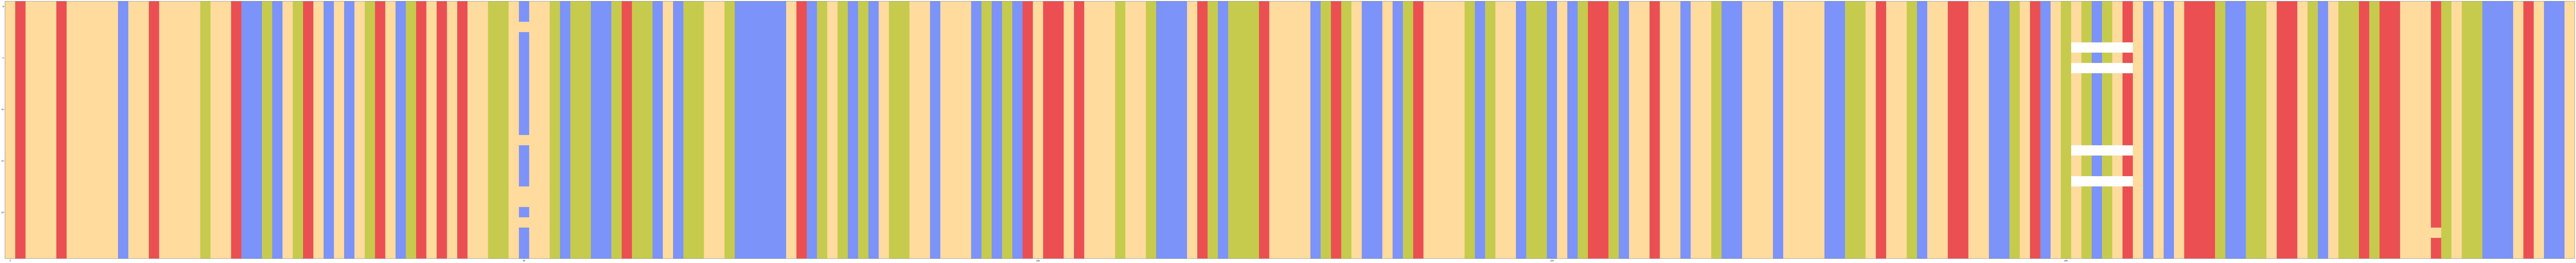

In [8]:
plt.figure(figsize=(250, 25), dpi=100)

plt.imshow(color_matrix)

There are 3 areas of mutation. The first mutation is in a column, we see that a column of "C" nuclotides (blue) sometimes changed into "T" nucleotides (yellow) in multiple places, which results in a blue vertical line with yellow dots scattered throughout. 
The second mutation is a deletion, we see that nucleotides have missing places, which results in white horizontal lines in multiple rows. 
The final mutation is only in one place of a row, we see that a column of "G" nucleotides (red) has changed into "T" nucleotide (yellow) in only one place.

Computing an [entropy score](http://bearcave.com/misl/misl_tech/wavelets/compression/shannon.html) for the original 100 sequences:

In [9]:
# takes a nucleotide matrix, returns its entropy score
def entropy(matrix):
     
    entropy_sum = 0
    d1, d2 = matrix.shape
    for j in range(d2):
        column_nucleotides = list() # keep a list of characters for each column
        column_entropy = 0
        
        for i in range(d1):
            
            char = matrix[i,j]
            column_nucleotides.append(char)
            
            nucleotide = Counter(column_nucleotides).keys() # store the unique nucleotide values of the column
            freqs = Counter(column_nucleotides).values() # count their appearance count
            sum_freqs = sum(freqs)
            freqs = [x / sum_freqs for x in freqs] # calculate their frequency

        for n in range(len(nucleotide)): # apply the entropy formula
            val = freqs[n] * math.log(freqs[n], 2)
            column_entropy -= val
            
        entropy_sum += column_entropy
        
    return entropy_sum

#### Entropy of November 27th spike protein data (of size 100 x 3822):

In [10]:
print(entropy(nucleotide_matrix))

282.90416996418224


# Part 2: Phylogenetic Tree

Extracting the spike protein gene from the first 4 patients of the samples from November 3, November 27, and December 8 and converting them into a nucleotite matrix.

In [7]:
arr = []

# read the data and take the first 4 observations for each file

with open("UK Coronavirus Data/Coronavirus Samples/England (NOV032020)/HCOV19-ENGLAND-031120-A.fasta") as handle:
    count = 0
    for record in SeqIO.parse(handle, "fasta"):
        while count < 4:
            arr.append(record.seq[21563:25385])
            count += 1
        
        break

with open("UK Coronavirus Data/Coronavirus Samples/England (NOV272020)/HCOV19-ENGLAND-271120-A.fasta") as handle:
    count = 0
    for record in SeqIO.parse(handle, "fasta"):
        while count < 4:
            arr.append(record.seq[21563:25385])
            count += 1
        
        break
        
with open("UK Coronavirus Data/Coronavirus Samples/England (DEC082020)/HCOV19-ENGLAND-081220-A.fasta") as handle:
    count = 0
    for record in SeqIO.parse(handle, "fasta"):
        while count < 4:
            arr.append(record.seq[21563:25385])
            count += 1
        
        break
        

nucleotide_matrix = np.array(arr)
nucleotide_matrix.shape

(12, 3822)

In [12]:
# change characters other than "A", "G", "T", "C" to "-"
for i in range(12):
    for j in range(3822):
        if nucleotide_matrix[i,j] not in ["A", "G", "T", "C", "-"]:
            nucleotide_matrix[i,j] = "-"

Computing the pairwise alignment score between all pairs of nucleotide sequences by using percent identity score (the amount of matched nucleotides / length of the sequence), and creating a pairwise similarity matrix of size 12 x 12.

In [13]:
# takes two sequences, returns their identity score (the amount of matched nucleotides / length of the sequence)
def compare(sequence1, sequence2):
    equality = list(np.array(sequence1==sequence2).reshape(-1,))
    matches = equality.count(True)
    length = len(equality)
    
    return matches/length  # returns identity score


In [15]:
# create an empty matrix to fill
score_matrix = np.full((12, 12), 0, dtype = float)

In [16]:
# compare each of the 12 rows with each other
for i in range(12):
    for j in range(12):
        # calculate the identity score between every pairs of sequences
        score = compare(nucleotide_matrix[i,:], nucleotide_matrix[j,:])  
        score_matrix[i, j] = score

In [17]:
print(score_matrix)

[[1.         1.         1.         1.         0.8762428  0.8762428
  0.8762428  0.8762428  0.87807431 0.87807431 0.87807431 0.87807431]
 [1.         1.         1.         1.         0.8762428  0.8762428
  0.8762428  0.8762428  0.87807431 0.87807431 0.87807431 0.87807431]
 [1.         1.         1.         1.         0.8762428  0.8762428
  0.8762428  0.8762428  0.87807431 0.87807431 0.87807431 0.87807431]
 [1.         1.         1.         1.         0.8762428  0.8762428
  0.8762428  0.8762428  0.87807431 0.87807431 0.87807431 0.87807431]
 [0.8762428  0.8762428  0.8762428  0.8762428  1.         1.
  1.         1.         0.99712193 0.99712193 0.99712193 0.99712193]
 [0.8762428  0.8762428  0.8762428  0.8762428  1.         1.
  1.         1.         0.99712193 0.99712193 0.99712193 0.99712193]
 [0.8762428  0.8762428  0.8762428  0.8762428  1.         1.
  1.         1.         0.99712193 0.99712193 0.99712193 0.99712193]
 [0.8762428  0.8762428  0.8762428  0.8762428  1.         1.
  1.     

Converting the pairwise similarity matrix to a pairwise distance matrix by subtracting every element of the pairwise similarity matrix from 1.

In [18]:
distance_matrix = 1 - score_matrix
distance_matrix

# naming each patient data to use on the phylogenetic tree
names = np.array(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"])

Converting the pairwise distance matrix to a lower triangular matrix. This is necessary because the phylogenetic tree construction function in the Bio package requires lower triangular matrices.

In [19]:
lower_distance_matrix = [distance_matrix[i][:i+1] for i in range(12)] # necessary to create a DistanceMatrix object
lower_distance_matrix

[array([0.]),
 array([0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.1237572, 0.1237572, 0.1237572, 0.1237572, 0.       ]),
 array([0.1237572, 0.1237572, 0.1237572, 0.1237572, 0.       , 0.       ]),
 array([0.1237572, 0.1237572, 0.1237572, 0.1237572, 0.       , 0.       ,
        0.       ]),
 array([0.1237572, 0.1237572, 0.1237572, 0.1237572, 0.       , 0.       ,
        0.       , 0.       ]),
 array([0.12192569, 0.12192569, 0.12192569, 0.12192569, 0.00287807,
        0.00287807, 0.00287807, 0.00287807, 0.        ]),
 array([0.12192569, 0.12192569, 0.12192569, 0.12192569, 0.00287807,
        0.00287807, 0.00287807, 0.00287807, 0.        , 0.        ]),
 array([0.12192569, 0.12192569, 0.12192569, 0.12192569, 0.00287807,
        0.00287807, 0.00287807, 0.00287807, 0.        , 0.        ,
        0.        ]),
 array([0.12192569, 0.12192569, 0.12192569, 0.12192569, 0.00287807,
        0.00287807, 0.00287807, 0.00287807, 0.        , 0.        ,
        0.        , 

Implementing the [neighbor joining algorithm](https://en.wikipedia.org/wiki/Neighbor_joining) from scratch to construct a phylogenetic tree of the given 12 samples, and printing the tree constructed in the [Newick format](https://en.wikipedia.org/wiki/Newick_format) with distances and leaf names.

In [20]:
# takes a distance matrix, returns the total distance of each sequence as a list
def tot_dist(matrix):
    total_distance = [] 
    x, y = matrix.shape # x == y so can use just one of them
    
    for i in range(x):
        seq_total = 0
        for j in range(x): # for each row, calculate the total_distance of that row to other rows
            seq_total += matrix[i,j]
        total_distance.append(seq_total)
        
    return total_distance


# takes a distance matrix, its rows total distances and row names, returns the Q-matrix and the 2 sequences to be
# merged that corresponds to the minimum value in the Q-matrix
def Q_matrix(matrix, total_dist, names):
    x, y = matrix.shape
    q_matrix = np.full((x, y), 0, dtype = float)
    
    for i in range(x):
        for j in range(x):
            if i==j:
                continue

            q_matrix[i,j] = (x-2)*matrix[i,j] - total_dist[i] - total_dist[j]
            
    val = np.where(q_matrix == q_matrix.min()) # finds the min value, i.e. the sequences to be joined
    
    # there can be multiple minimum values, take the first one
    seq1 = val[0][0] # first seq of corresponding min value
    seq2 = val[1][0] # second seq of corresponding min value
    
    return q_matrix, seq1, seq2


# takes indices of the sequences to be merged, their weights and row names, returns the result of their merging 
# in a Newick format (ex: "A:1, B:2") and the updated list of names with the new row of merged row
def merge(node1, node2, weight1, weight2, names):
    # get the names of the rows to be merged
    name1 = names[node1] 
    name2 = names[node2]
    
    # remove their old names
    names = np.delete(names,(node1, node2))
    
    # result of their merging in a Newick format (ex: "A:1, B:2")
    merged =  name1 + ":" + str(weight1) + "," + name2 + ":" + str(weight2) 
    
    # create the new merged name but first, check if one of the rows (or both) is already a combination of rows. 
    # If so, put parantheses around that particular row's name. 
    if "+" not in name1 and "+" not in name2: # merging A and B: A+B
        string = name1 + "+" + name2
        names = np.append(names, string)
    elif "+" in name1 and "+" not in name2: # merging A+B and C: (A+B)+C
        string = "(" + name1 + ")" + "+" + name2
        names = np.append(names, string)
    elif "+" not in name1 and "+" in name2: # merging A and B+C: A+(B+C)
        string = name1 + "+" + "(" + name2 + ")"
        names = np.append(names, string) 
    else: # merging A+B and C+D: (A+B)+(C+D)
        string = "(" + name1 + ")" + "+" + "(" + name2 + ")"
        names = np.append(names, string)
    
    return merged, names
    

# takes the indices of the rows to be merged, returns their edge weight in the tree according the formula
def branch_weight(node1, node2, matrix, total_dist):
    x, y = matrix.shape
    
    node1_weight = (0.5 * matrix[node1,node2]) + (((total_dist[node1]) - total_dist[node2])/(2*(x-2))) 
    node2_weight = matrix[node1,node2] - node1_weight
    
    return node1_weight, node2_weight


# takes the distance matrix, indices of rows to be merged, names list previous to merge and after the merge
# returns the updated distance matrix after the merge
def update_distance(matrix, node1, node2, pre_names, after_names):
    distances1 = matrix[:, node1] # distances of node1 to other nodes
    distances2 = matrix[:, node2] 
    
    # delete the row and column corresponding to node1 and node2
    matrix = np.delete(matrix, (node1,node2), 0) # delete row
    matrix = np.delete(matrix, (node1,node2), 1) # delete column

    x,y = matrix.shape
    
    new_dists = []
            
    # calculate distances to the new merged node 
    for i in range(x):
        index_i = np.where(pre_names == after_names[i])
        dist = (distances1[index_i] + distances2[index_i] - distances1[node2]) / 2
        new_dists.append(float(dist))
    
    # append a last column and row, this new column and row corresponds to the new merged node and its distances
    matrix = np.vstack([matrix, new_dists]) 
    new_dists.append(0)
    new_dists = np.array(new_dists).reshape(x+1,1)
    matrix = np.hstack([matrix, new_dists])
    
    l = len(new_dists)
    
    for i in range(l):
        matrix[i, l-1] = new_dists[i]
        
    
    return matrix


In [21]:
# takes a distance matrix and a list of row names, performs one iteration of neighbor joining algorithm and 
# returns the updated distance matrix, updated names and the merged value in Newick Format
def neigbor_joining(f_distance_matrix, f_names):
    x,y = f_distance_matrix.shape
    
    # for the final iteration, return 0 as the distance matrix, and their merged value with the non-zero value 
    # in the matrix as edge weight
    if x == 2:
        f_new_names = "(" + f_names[0] + ")" + "+" + "(" + f_names[1] + ")"
        f_merged =  f_names[0] + ":" + str(f_distance_matrix[0, 1]) + "," + f_names[1] + ":" + str(f_distance_matrix[0, 1]) 
        
        f_new_distance_matrix = 0
        
        return f_new_distance_matrix, f_new_names, f_merged
    
    else:
    
        # calculate total distance for each sequence
        f_total_distances = tot_dist(f_distance_matrix)

        # calculate Q-matrix, get the values: Q-matrix, sequence1 to be merged and sequence2 to be merged
        f_Q_results = Q_matrix(f_distance_matrix, f_total_distances, f_names)

        # calculate the edge weights of sequence1 and sequence2
        f_weights = branch_weight(f_Q_results[1], f_Q_results[2], f_distance_matrix, f_total_distances)

        # merge sequence1 and sequence2 with their corresponding edge weights
        f_merged = merge(f_Q_results[1], f_Q_results[2], f_weights[0], f_weights[1], f_names)
        
        # update names list
        f_old_names = f_names
        f_new_names = f_merged[1]
        
        # update distance matrix
        f_new_distance_matrix = update_distance(f_distance_matrix, f_Q_results[1], f_Q_results[2], f_old_names, f_new_names)

        return f_new_distance_matrix, f_new_names, f_merged[0]


In [22]:
# a list to store all the return values of the merged rows in each iteration
newick = []

# apply neighbor joining algorithm to the distance matrix until there are 2 rows left
while True:
    result = neigbor_joining(distance_matrix, names)
        
    newick.append(result[2])

    distance_matrix = result[0]
    names = result[1]
    
    if not isinstance(distance_matrix, np.ndarray):
        break

Representation of the tree in the Newick format:

In [24]:
print(newick)

['A:0.0,B:0.0', 'C:0.0,D:0.0', 'A+B:0.0,C+D:0.0', 'E:0.0,F:0.0', 'G:0.0,H:0.0', 'E+F:0.0,G+H:0.0', '(A+B)+(C+D):0.12140240711669281,(E+F)+(G+H):0.0023547880690738543', 'I:0.0,J:0.0', 'K:0.0,L:0.0', '((A+B)+(C+D))+((E+F)+(G+H)):0.0005232862375719183,I+J:0.0', 'K+L:0.0,(((A+B)+(C+D))+((E+F)+(G+H)))+(I+J):0.0']


In [26]:
# creating a new class for constructing the trees
class node:
  def __init__(self, name, value):
    self.name = name
    self.value = value

In [30]:
# converting the return value to the Newick format. 

# using the newick list, build upon the merged values one at a time using nodes. Each merged node has a name 
# and a value, their name is the merged name with + sign and their value is it's corresponding Newick format.

# To give an example for 2 iterations: Assume for A, B, C nodes first A and B is merged with weights 1 and 2 and
# then A+B and C is merged with weights 3 and 4. This would've been stored in the newick list as:
# ["A:1, B:2", "A+B:3, C:4"]. We iterate through each element and create nodes. For the first element "A:1, B:2"
# there are no plus signs in each sequence so simply create a merged node where node.name = A+B and 
# node.value = (A:1, B:2). In the next iteration "A+B:3, C:4", A+B has plus sign so we look for that value 
# in the nodes list. A node where name is A+B is found, and it's value is (A:1, B:2), so we replace the string 
# "A+B" with the node value to create "(A:1, B:2):3, C:4". 

nodes = [] 


for choice in newick:
    choice_nodes = choice.split(",") # getting each row name with its weight
    ns = ""
    for element in choice_nodes:
        name = element.split(':')[0]
        if "+" in name: # look for names in the nodes list if + is in the name
            for other in nodes:
                if other.name == name:
                    choice = choice.replace(name, other.value)
                    
            name = "(" + name + ")"
            
        ns += name
        ns += "+" # add plus after each row name
    
    ns = ns[:len(ns)-1] # adding + after each row name creates A+B+, remove the final +
    new = node(ns, "(" + choice + ")")  
    nodes.append(new)
                
text = nodes[-1].value + ";"
print(text)

((K:0.0,L:0.0):0.0,((((A:0.0,B:0.0):0.0,(C:0.0,D:0.0):0.0):0.12140240711669281,((E:0.0,F:0.0):0.0,(G:0.0,H:0.0):0.0):0.0023547880690738543):0.0005232862375719183,(I:0.0,J:0.0):0.0):0.0);


Visualizing the phylogenetic tree from Newick formatted input, using the Phylo module of Biopython package. 

<Figure size 20000x10000 with 0 Axes>

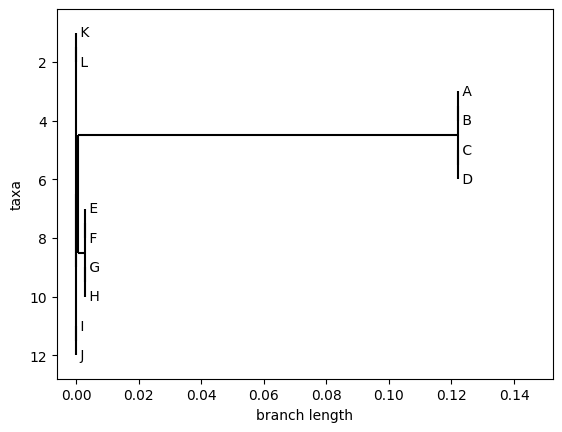

In [32]:
io_text = StringIO(text)
tree = Phylo.read(io_text, "newick")

fig = plt.figure(figsize=(200, 100), dpi=100)
Phylo.draw(tree, do_show=False)

Using the neighbor joining algorithm provided in the Phylo module and comparing results:

In [34]:
m = []

for elt in lower_distance_matrix:
    m.append(elt.tolist())

In [35]:
distance_matrix_e = DistanceMatrix(names=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"], matrix=m)

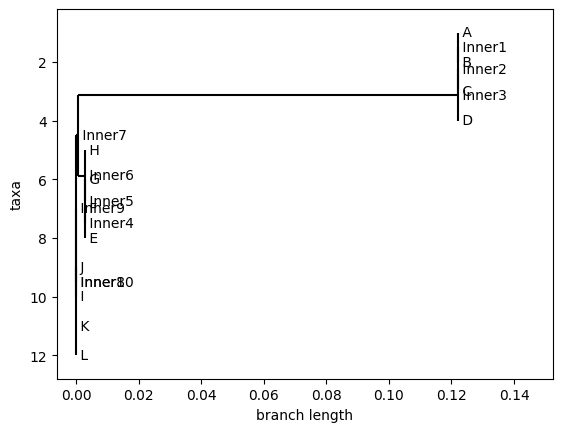

In [36]:
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix_e)

# Draw the phylogenetic tree
Phylo.draw(tree)

The names are difficult to read because of the Inner labels, but they seem to be similar. The only visible difference is that in the phylogenetic tree constructed previously, merged K-L leaf is the first taxa (taxa 1) but in the phylogenetic tree constructed with Phylo module K-L leaf is the last taxa. However, all the merged leaf names and their weights seem to be the same. The only difference is their order.

Extracting the spike protein gene from all patients from November 3, November 27, and December 8 and formatting the data into a nucleotide matrix of size 100 x 3822. Removing nucleotide data other than A, G, T, C, and -. Finally, using the Phylo module to construct and visualize the phylogenetic tree of these sequences.

In [8]:
arr = []

with open("UK Coronavirus Data/Coronavirus Samples/England (NOV032020)/HCOV19-ENGLAND-031120-A.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        arr.append(record.seq[21563:25385])

with open("UK Coronavirus Data/Coronavirus Samples/England (NOV272020)/HCOV19-ENGLAND-271120-A.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        arr.append(record.seq[21563:25385])
        
with open("UK Coronavirus Data/Coronavirus Samples/England (DEC082020)/HCOV19-ENGLAND-081220-A.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
            arr.append(record.seq[21563:25385])
        
nucleotide_matrix = np.array(arr)

for i in range(298):
    for j in range(3822):
        if nucleotide_matrix[i,j] not in ["A", "G", "T", "C", "-"]:
            nucleotide_matrix[i,j] = "-"
            
print(nucleotide_matrix.shape)

# I couldn't use Phylo library's calculator.get_distance() function with the created nucleotide_matrix in
# numpy.array format. So instead, I am creating a MultipleSeqAlignment object (from Phylo library)
# from the rows of nucleotide_matrix to pass it to calculator.

sequences = ["".join(item) for item in nucleotide_matrix]
seq = MultipleSeqAlignment([])

for i in range(298):
    # I am using the integers [0,298] because otherwise the constructed tree was unreadable
    record = SeqRecord(Seq(sequences[i]), id=str(i)) 
    seq.append(record)

print("Rows 20-24 from the created MultipleSeqAlignment object:")
print(seq[20:25]) # sample from the MultipleSeqAlignment object

calculator = DistanceCalculator('identity')
distMatrix = calculator.get_distance(seq)

(298, 3822)
Rows 20-24 from the created MultipleSeqAlignment object:
Alignment with 5 rows and 3822 columns
TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGT...AAA 20
TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGT...AAA 21
TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGT...AAA 22
TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGT...AAA 23
TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGT...AAA 24


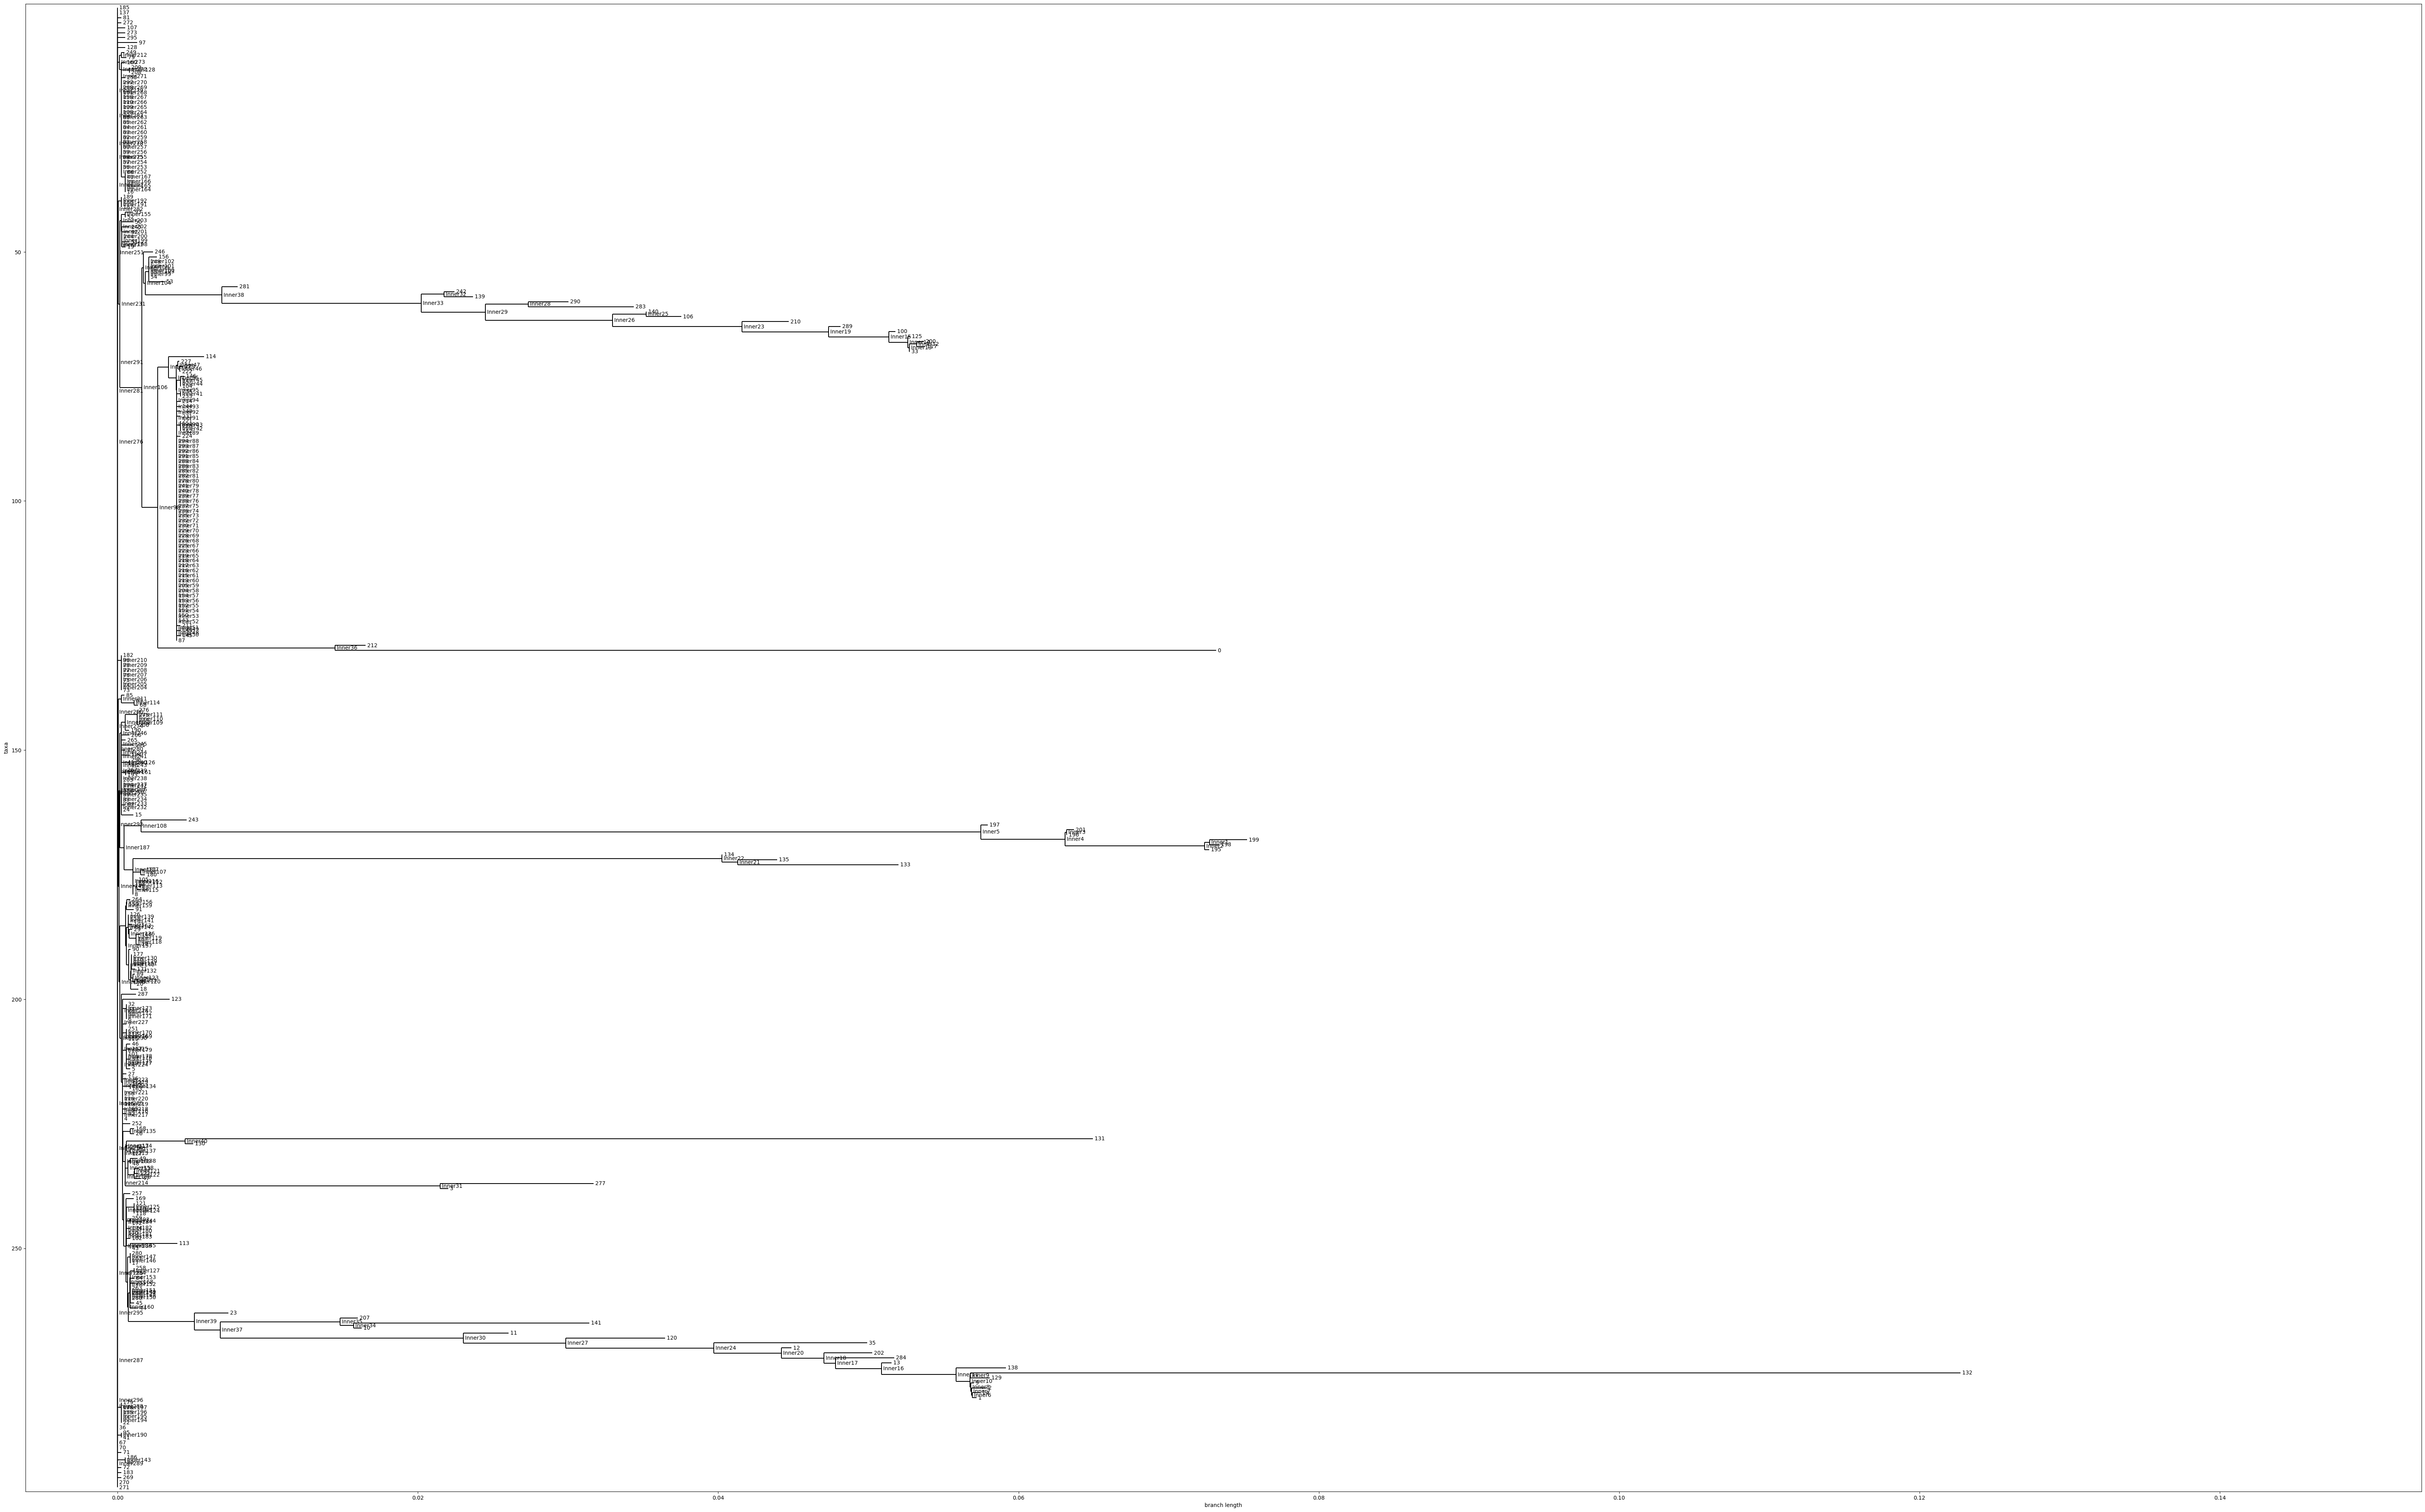

In [9]:
constructor = DistanceTreeConstructor()

tree = constructor.nj(distMatrix)

fig = plt.figure(figsize=(80, 50), dpi=100)
axes = fig.add_subplot(1, 1, 1)

# Draw the phylogenetic tree
Phylo.draw(tree, axes=axes, do_show=False)